In [1]:

# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

In [2]:
# load dataset
dataset = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [3]:
dataset.shape

(4857377, 8)

In [4]:
# peek at data
set_option('display.width', 100)
dataset.tail(2)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202
4857376,1617148800,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363


In [5]:
#NANを補完
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [6]:

dataset=dataset.drop(columns=['Timestamp'])

In [7]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [8]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
4857372,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,58695.262,58667.759333,1.0
4857373,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,58693.564,58667.410167,1.0
4857374,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,58698.178,58667.708333,1.0
4857375,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,58709.824,58668.532333,1.0
4857376,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363,58718.698,58670.550500,1.0


In [9]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [10]:

#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
4857372,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,58695.262,58667.759333,1.0,...,49.479206,35.393068,61.578052,51.696846,68.137666,39.264052,47.839895,58695.262,58676.974333,58717.26280
4857373,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,58693.564,58667.410167,1.0,...,49.477515,35.232460,44.601858,51.582924,57.317024,34.155329,39.805778,58693.564,58675.469333,58717.92555
4857374,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,58698.178,58667.708333,1.0,...,49.822376,67.379544,46.001691,74.385418,59.221729,41.880662,38.433347,58698.178,58675.542333,58718.66155
4857375,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,58709.824,58668.532333,1.0,...,50.152827,91.130640,64.580881,94.261430,73.409924,51.700826,42.578939,58709.824,58675.947000,58719.38035
4857376,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363,58718.698,58670.550500,1.0,...,50.310243,100.000000,86.170061,100.000000,89.548949,56.401144,49.994210,58718.698,58677.057000,58720.38225


In [11]:

dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
4857372,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,58695.262,58667.759333,1.0,...,49.479206,35.393068,61.578052,51.696846,68.137666,39.264052,47.839895,58695.262,58676.974333,58717.26280
4857373,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,58693.564,58667.410167,1.0,...,49.477515,35.232460,44.601858,51.582924,57.317024,34.155329,39.805778,58693.564,58675.469333,58717.92555
4857374,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,58698.178,58667.708333,1.0,...,49.822376,67.379544,46.001691,74.385418,59.221729,41.880662,38.433347,58698.178,58675.542333,58718.66155
4857375,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,58709.824,58668.532333,1.0,...,50.152827,91.130640,64.580881,94.261430,73.409924,51.700826,42.578939,58709.824,58675.947000,58719.38035
4857376,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363,58718.698,58670.550500,1.0,...,50.310243,100.000000,86.170061,100.000000,89.548949,56.401144,49.994210,58718.698,58677.057000,58720.38225


In [12]:
#excluding columns that are not needed for our prediction.

dataset=dataset.drop(['High','Low','Open', 'Volume_(Currency)','short_mavg','long_mavg'], axis=1)

In [13]:

dataset = dataset.dropna(axis=0)

In [14]:

dataset.tail()

,Close,Volume_(BTC),Weighted_Price,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
4857372,58686.00,1.384487,58692.753339,1.0,58691.231169,58675.537971,58722.002882,-0.028602,-0.076552,19.46,...,49.479206,35.393068,61.578052,51.696846,68.137666,39.264052,47.839895,58695.262,58676.974333,58717.26280
4857373,58685.81,7.294848,58693.226508,1.0,58690.245502,58676.200682,58721.642754,0.013821,-0.061034,-16.98,...,49.477515,35.232460,44.601858,51.582924,57.317024,34.155329,39.805778,58693.564,58675.469333,58717.92555
4857374,58723.84,1.705682,58696.198496,1.0,58696.353592,58679.274187,58721.664617,0.135922,-0.041890,46.14,...,49.822376,67.379544,46.001691,74.385418,59.221729,41.880662,38.433347,58698.178,58675.542333,58718.66155
4857375,58760.59,0.720415,58761.866202,1.0,58708.032939,58684.520368,58722.051935,0.121231,0.026743,116.46,...,50.152827,91.130640,64.580881,94.261430,73.409924,51.700826,42.578939,58709.824,58675.947000,58719.38035
4857376,58778.18,2.712831,58764.349363,1.0,58720.786950,58690.562925,58722.610423,0.133356,0.071762,88.74,...,50.310243,100.000000,86.170061,100.000000,89.548949,56.401144,49.994210,58718.698,58677.057000,58720.38225


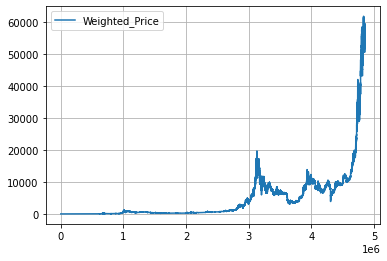

In [15]:
dataset[['Weighted_Price']].plot(grid=True)
plt.show()

In [18]:
print(dataset.columns)

Index(['Close', 'Volume_(BTC)', 'Weighted_Price', 'signal', 'EMA10', 'EMA30', 'EMA200', 'ROC10',
       'ROC30', 'MOM10', 'MOM30', 'RSI10', 'RSI30', 'RSI200', '%K10', '%D10', '%K30', '%D30',
       '%K200', '%D200', 'MA21', 'MA63', 'MA252'],
      dtype='object')


In [52]:
dataset['pctc'] = dataset['Close'].pct_change(-1)*(-1)

In [53]:
dataset['pctc'].tail(20)

4857357    0.000073
4857358   -0.000208
4857359   -0.000143
4857360   -0.000000
4857361    0.001134
4857362    0.000618
4857363   -0.000428
4857364   -0.000572
4857365    0.000772
4857366    0.000178
4857367   -0.000000
4857368   -0.000024
4857369    0.000706
4857370   -0.000437
4857371   -0.000482
4857372   -0.000003
4857373    0.000648
4857374    0.000625
4857375    0.000299
4857376         NaN
Name: pctc, dtype: float64

In [54]:
dataset['pctc'].tail(20)

4857357    0.000073
4857358   -0.000208
4857359   -0.000143
4857360   -0.000000
4857361    0.001134
4857362    0.000618
4857363   -0.000428
4857364   -0.000572
4857365    0.000772
4857366    0.000178
4857367   -0.000000
4857368   -0.000024
4857369    0.000706
4857370   -0.000437
4857371   -0.000482
4857372   -0.000003
4857373    0.000648
4857374    0.000625
4857375    0.000299
4857376         NaN
Name: pctc, dtype: float64

In [55]:
print(dataset['pctc'].describe())

count    4.357589e+06
mean    -8.985196e-05
std      1.874994e-01
min     -3.913733e+02
25%     -2.737257e-04
50%     -0.000000e+00
75%      2.980854e-04
max      9.974318e-01
Name: pctc, dtype: float64


In [57]:
ran = 0.0002

dataset['hantei'] = 0
dataset.loc[dataset['pctc'] > ran, 'hantei'] = 1
dataset.loc[dataset['pctc'] < -1*ran, 'hantei'] = -1



In [67]:
dataset[['Close','pctc','hantei']].tail(30)

,Close,pctc,hantei
4857347,58736.03,0.000339,1
4857348,58755.94,-0.000873,-1
4857349,58704.68,0.000410,1
4857350,58728.74,-0.001005,-1
4857351,58669.75,-0.000708,-1
4857352,58628.24,0.000243,1
4857353,58642.47,-0.000721,-1
4857354,58600.20,0.000277,1
4857355,58616.45,-0.000002,0
4857356,58616.33,-0.000000,0


In [81]:
dataset.tail()

,Close,Volume_(BTC),EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,...,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252,pctc,hantei
4857371,58714.31,2.519999,58692.393651,58674.816451,58722.364720,0.081426,0.037228,114.31,40.46,58.717030,...,74.813962,68.671304,72.479703,45.997954,53.053891,58693.316,58677.189667,58716.59275,-0.000482,-1
4857372,58686.00,1.384487,58691.231169,58675.537971,58722.002882,-0.028602,-0.076552,19.46,-6.46,51.543510,...,61.578052,51.696846,68.137666,39.264052,47.839895,58695.262,58676.974333,58717.26280,-0.000003,0
4857373,58685.81,7.294848,58690.245502,58676.200682,58721.642754,0.013821,-0.061034,-16.98,-45.15,51.496595,...,44.601858,51.582924,57.317024,34.155329,39.805778,58693.564,58675.469333,58717.92555,0.000648,1
4857374,58723.84,1.705682,58696.353592,58679.274187,58721.664617,0.135922,-0.041890,46.14,2.19,59.662168,...,46.001691,74.385418,59.221729,41.880662,38.433347,58698.178,58675.542333,58718.66155,0.000625,1
4857375,58760.59,0.720415,58708.032939,58684.520368,58722.051935,0.121231,0.026743,116.46,12.14,65.837408,...,64.580881,94.261430,73.409924,51.700826,42.578939,58709.824,58675.947000,58719.38035,0.000299,1


In [80]:
dataset=dataset.drop(index=4857376)

In [72]:
dataset=dataset.drop(['Weighted_Price', 'signal'], axis=1)

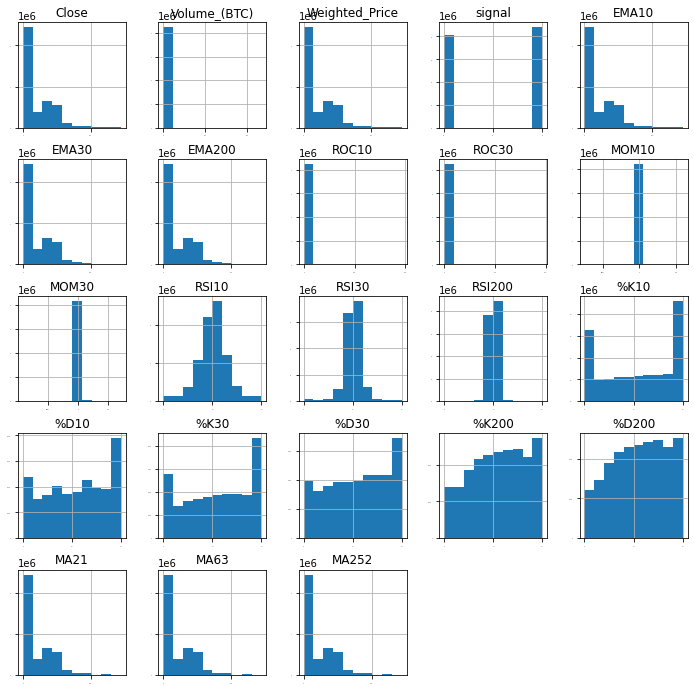

In [17]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

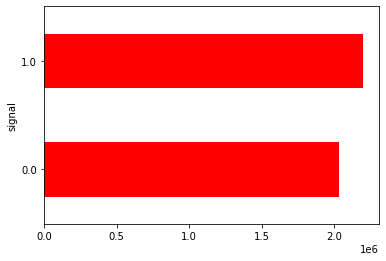

In [18]:

fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

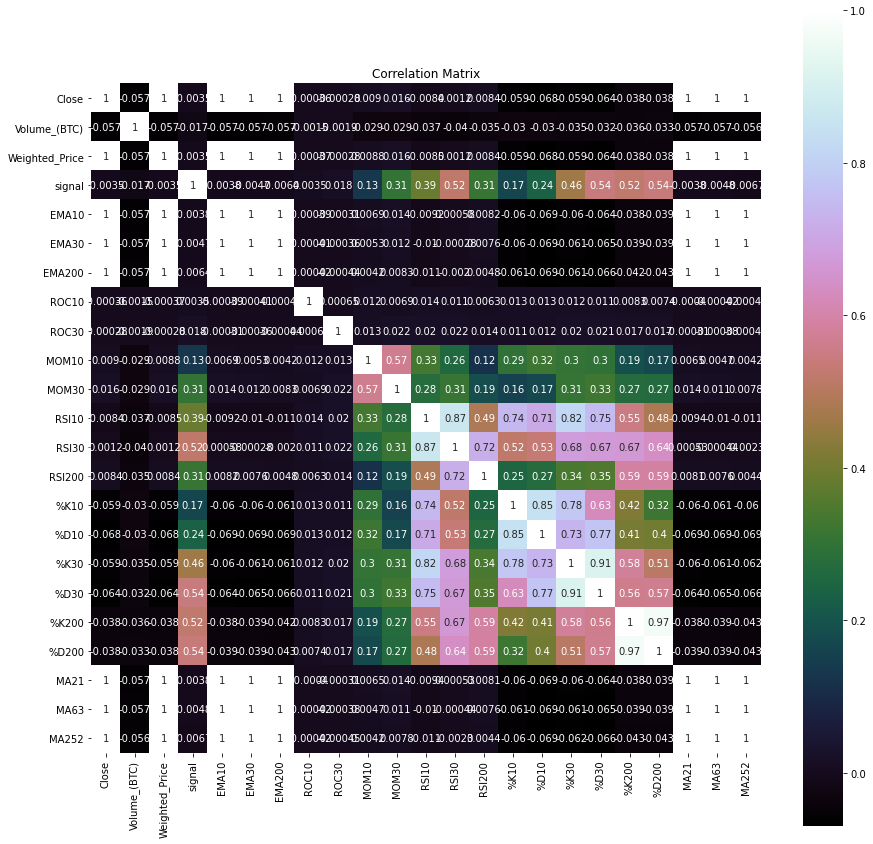

In [19]:

# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

In [82]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["hantei"]
X = subset_dataset.loc[:, dataset.columns != 'hantei']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [83]:

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

In [84]:

# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [ ]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=None)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.445700 (0.005476)
LDA: 0.847363 (0.002595)
KNN: 0.407950 (0.007274)
CART: 0.999775 (0.000156)
NB: 0.352075 (0.004576)


c:\users\admin\miniconda3\envs\jp\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\admin\miniconda3\envs\jp\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


NN: 0.375275 (0.108826)
AB: 0.999737 (0.000131)


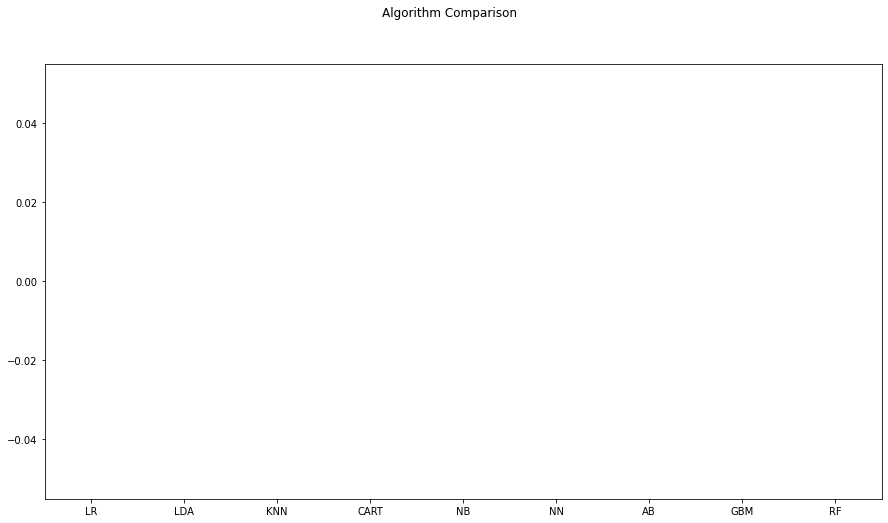

In [78]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

In [27]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
'''   
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.913625 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#5 0.883950 (0.006123) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.883325 (0.004816) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.911650 (0.004986) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.913625 (0.003888) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.882463 (0.003932) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#8 0.882362 (0.004752) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.909750 (0.003780) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#2 0.912213 (0.004574) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [28]:

# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [29]:

# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9137
[[8383  810]
 [ 916 9891]]
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91      9193
         1.0       0.92      0.92      0.92     10807

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

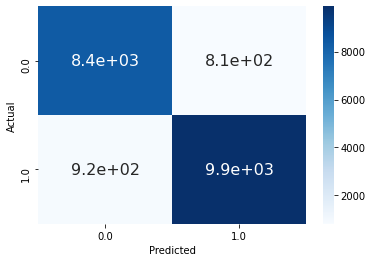

In [30]:

df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

Text(0.5, 0, 'Variable Importance')

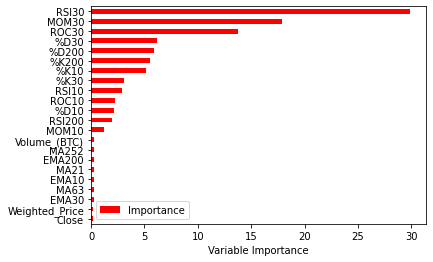

In [31]:

Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

<AxesSubplot:>

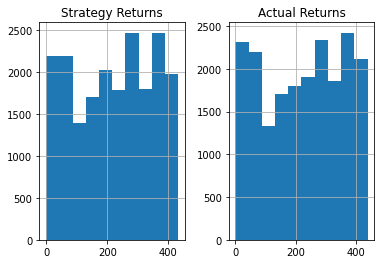

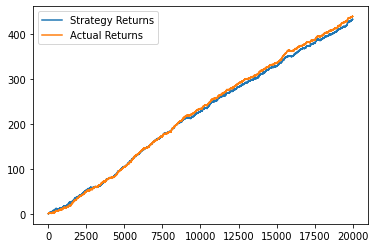

In [32]:

#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()